In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from joblib import dump
from xgboost import XGBRegressor
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


In [9]:

# --- 1. Carregando os CSVs ---
x_train = pd.read_csv('../data/processed/x_train_encoded.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

x_test = pd.read_csv('../data/processed/x_test_encoded.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def avaliar_modelo_final(model_class, best_params, x_train, y_train, x_test, y_test, n_runs=30, random_state_base=42):
    """
    Roda o modelo n_runs vezes e avalia no conjunto de teste.
    Retorna um DataFrame com as métricas de cada rodada.
    """
    resultados = []
    
    for i in range(n_runs):
        # Criar modelo com mesma config mas seeds diferentes
        model = model_class(random_state=random_state_base + i, **best_params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        resultados.append({"Run": i+1, "MAE": mae, "RMSE": rmse, "R2": r2})
    
    return pd.DataFrame(resultados)

# Exemplo de uso:
best_xgb_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

In [ ]:

resultados_test = avaliar_modelo_final(XGBRegressor, best_xgb_params, x_train, y_train, x_test, y_test, n_runs=30)

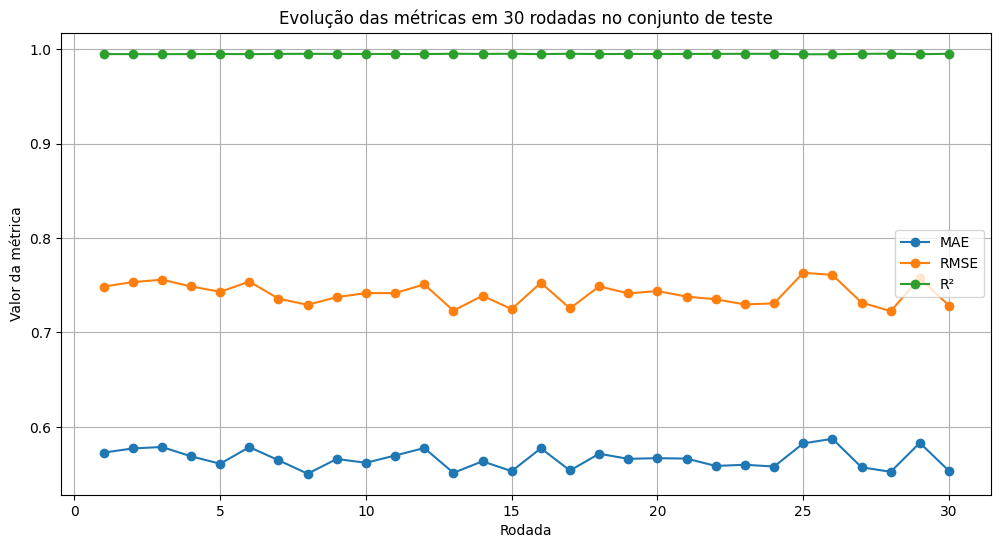

In [15]:
plt.figure(figsize=(12,6))
plt.plot(resultados_test['Run'], resultados_test['MAE'], marker='o', label='MAE')
plt.plot(resultados_test['Run'], resultados_test['RMSE'], marker='o', label='RMSE')
plt.plot(resultados_test['Run'], resultados_test['R2'], marker='o', label='R²')

plt.xlabel('Rodada')
plt.ylabel('Valor da métrica')
plt.title('Evolução das métricas em 30 rodadas no conjunto de teste')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(resultados_test.describe()[['MAE','RMSE','R2']])

             MAE       RMSE         R2
count  30.000000  30.000000  30.000000
mean    0.566448   0.741240   0.994780
std     0.010537   0.011737   0.000165
min     0.550519   0.722592   0.994468
25%     0.558289   0.731049   0.994652
50%     0.566204   0.741510   0.994778
75%     0.576149   0.750377   0.994924
max     0.587481   0.763184   0.995041


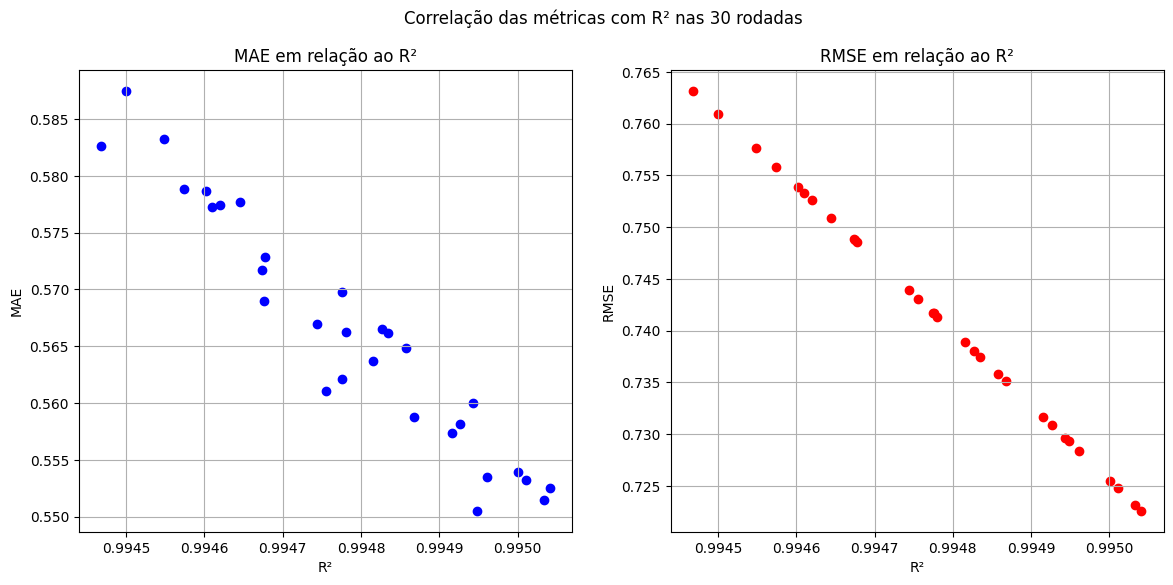

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(resultados_test['R2'], resultados_test['MAE'], color='blue', label='MAE vs R²')
ax[0].set_xlabel('R²')
ax[0].set_ylabel('MAE')
ax[0].set_title('MAE em relação ao R²')
ax[0].grid(True)

ax[1].scatter(resultados_test['R2'], resultados_test['RMSE'], color='red', label='RMSE vs R²')
ax[1].set_xlabel('R²')
ax[1].set_ylabel('RMSE')
ax[1].set_title('RMSE em relação ao R²')
ax[1].grid(True)

plt.suptitle('Correlação das métricas com R² nas 30 rodadas')
plt.show()

___
## Testes Estátisticos do modelo escolhido 

In [12]:
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy.stats import shapiro, normaltest, probplot
    
# Treinar o modelo final com os melhores hiperparâmetros
final_model = XGBRegressor(random_state=42, **best_xgb_params)
final_model.fit(x_train, y_train)

y_pred = final_model.predict(x_test)
residuos = y_test.values.flatten() - y_pred

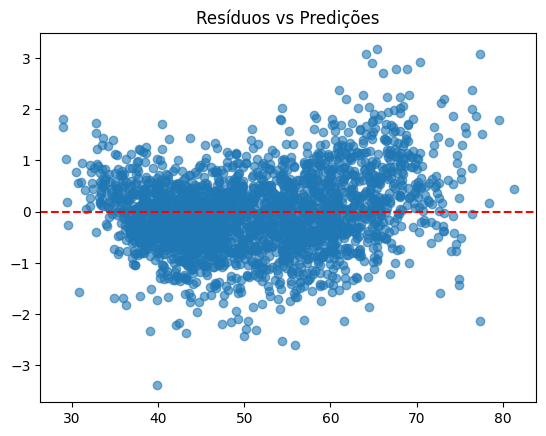

In [13]:
# --- Linearidade ---
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Resíduos vs Predições")
plt.show()

#### Resíduos vs Predições

Os resíduos estão distribuídos ao redor de zero, mas há uma leve concentração maior nos valores médios.

Não há padrão óbvio, o que sugere que o modelo capturou bem a relação entre as variáveis. Pequenas áreas de dispersão maior nos extremos podem indicar que o modelo erra um pouco mais para valores altos ou baixos, mas nada alarmante.

Durbin-Watson: 1.994


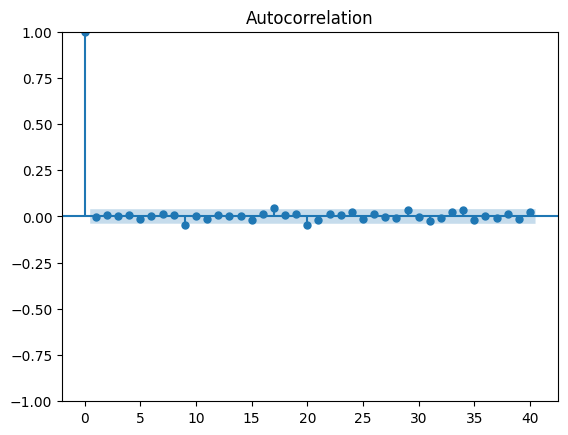

In [14]:
# --- Independência ---
dw = durbin_watson(residuos)
print(f"Durbin-Watson: {dw:.3f}")
sm.graphics.tsa.plot_acf(residuos, lags=40)
plt.show()

```
H0  (hipótese nula):  Não há correlação entre os resíduos.
Ha  (hipótese alternativa):  Os resíduos são autocorrelacionados.
```
Com o teste de Durbin-Watson = 1.994 (menor que 2 e maior que 1.5) indica uma correlação serial positiva, ou seja, os resíduos são independentes, sem autocorrelação significativa.

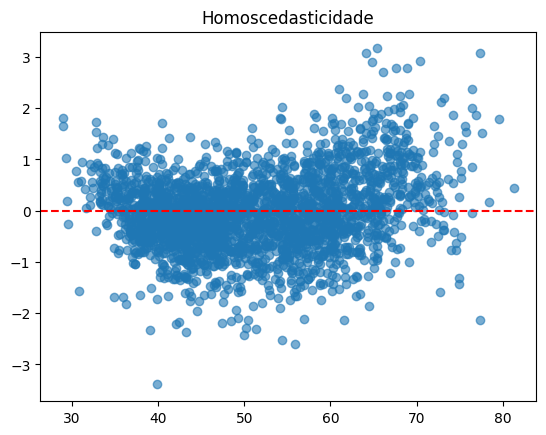

In [15]:
# --- Homoscedasticidade ---
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Homoscedasticidade")
plt.show()

O gráfico de resíduos vs predições não mostra um funil evidente a variância dos erros é aproximadamente constante, ou seja, o modelo não tende a errar mais em determinados níveis de predição.

Shapiro-Wilk: estatística=0.990, p-valor=0.000


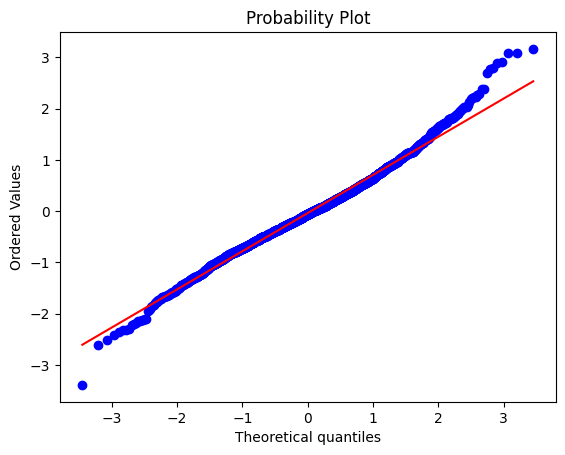

In [16]:
# --- Normalidade ---
stat, p = shapiro(residuos)
print(f"Shapiro-Wilk: estatística={stat:.3f}, p-valor={p:.3f}")
probplot(residuos, dist="norm", plot=plt)
plt.show()

Shapiro-Wilk: estatística = 0.990, p-valor = 0.000

O Q-Q plot dos resíduos seguem a linha central na maior parte, mas os extremos se desviam.

Os resíduos não são perfeitamente normais, principalmente nas extremidades (valores muito altos ou muito baixos). 

Para XGBoost isso não é crítico, mas indica que o modelo pode subestimar ou superestimar valores extremos.

---
### Serializando o modelo em um arquivo pkl

In [ ]:
x_train = pd.read_csv('../data/raw/test_split/x_train.csv')
y_train = pd.read_csv('../data/raw/test_split/y_train.csv')

x_test = pd.read_csv('../data/raw/test_split/x_test.csv')
y_test = pd.read_csv('../data/raw/test_split/y_test.csv')

In [ ]:
# --- 1. Definindo colunas para cada tipo de pré-processamento ---

col_one_hot = ['tipo_servico']
col_ordinal = [
    'mix_receita', 'parcerias', 'investimento_externo', 'branding_reputacao',
    'network_time', 'uso_tecnologia', 'roadmap_produto', 'eficiencia_operacional',
    'escala_tecnologica', 'financas_unidade', 'experiencia_lideranca',
    'treinamento', 'governanca_financeira'
]

# --- 2. Ordem das categorias para o OrdinalEncoder ---
ordinal_categories = [
    ['1–2 clientes >50%', '3–5 clientes >50%', 'Receita diversificada'],      
    ['Nenhuma', 'Poucas', 'Algumas', 'Muitas'],                               
    ['Não', 'Aceleradora/Anjo', 'Seed/Pré-Série A', 'Série A+'],              
    ['Não reconhecida', 'Algum reconhecimento', 'Reconhecimento forte'],      
    ['Não', 'Ocasionalmente', 'Sim, forte'],                                  
    ['Baixo', 'Médio', 'Alto'],                                               
    ['Não existe', 'Parcial', 'Claro e executado'],                           
    ['Quase nada', 'Parcialmente', 'Quase tudo'],                             
    ['Não', 'Parcialmente', 'Sim'],                                           
    ['Não', 'Algumas', 'Sim, regularmente'],                                  
    ['Sem experiência', 'Experiência parcial', 'Experiência forte'],          
    ['Nunca', 'Às vezes', 'Regularmente'],                                    
    ['Não existem controles', 'Controles básicos', 'DRE e auditoria']         
]

# --- 3. Criando encoders ---
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

# --- 4. Criando pré-processador com normalização ---
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_encoder, col_one_hot),
        ('ordinal', ordinal_encoder, col_ordinal),
        ('scaler', StandardScaler(), list(set(x_train.columns) - set(col_one_hot) - set(col_ordinal)))
    ],
    remainder='drop'
)

# --- Criar pipeline final com preprocessor + modelo ---
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=300,
        subsample=0.8
    ))
])

# Treinar o pipeline inteiro com dados crus (sem pré-processamento manual antes)
final_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['tipo_servico']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['1–2 '
                                                                              'clientes '
                                                                              '>50%',
                                                                              '3–5 '
                                                                              'clientes '
                                                                              '>50%',
                                                                              'Receita '
                                                                              'diversificada'],
                                                                             ['Nenhuma',
                                                                              'Poucas',
                                                                              'Algumas',
                                                                              'Muitas'],
                                                                             ['Não',
                                                                              'Aceleradora/Anjo',
                                                                              'Seed/Pré-Série '
                                                                              'A',
                                                                              'Série '
                                                                              'A+'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [2]:
# Salvar o pipeline inteiro no arquivo .pkl
dump(final_model, 'modelo_startup.pkl')
print("Pipeline + Modelo salvo com sucesso em 'modelo_startup.pkl'")

Pipeline + Modelo salvo com sucesso em 'modelo_startup.pkl'
